# Open NETCDF 4 Climate Data in Open Source Python Using Xarray

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# netCDF4 needs to be installed in your environment for this to work
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [2]:
# The (online) url for a MACAv2 dataset for max monthly temperature
data_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc"

max_temp_xr  = xr.open_dataset(data_path)  
# View xarray object
max_temp_xr

<xarray.Dataset>
Dimensions:          (lat: 585, crs: 1, lon: 1386, time: 672)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 1950-01-15 00:00:00 ... 2005-12-15 00:00:00
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [3]:
# For later - grab the crs of the data using rioxarra
climate_crs = max_temp_xr.rio.crs
climate_crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [4]:
# View first 5 latitude values
max_temp_xr["air_temperature"]["lat"].values[:5]

print("The min and max latitude values in the data is:", 
      max_temp_xr["air_temperature"]["lat"].values.min(), 
      max_temp_xr["air_temperature"]["lat"].values.max())
print("The min and max longitude values in the data is:", 
      max_temp_xr["air_temperature"]["lon"].values.min(), 
      max_temp_xr["air_temperature"]["lon"].values.max())


The min and max latitude values in the data is: 25.063077926635742 49.39602279663086
The min and max longitude values in the data is: 235.22784423828125 292.93524169921875


In [5]:
# View first 5 and last. 5 time values - notice the span of
# dates range from 1950 to 2005

print("The earliest date in the data is:", max_temp_xr["air_temperature"]["time"].values.min())
print("The latest date in the data is:", max_temp_xr["air_temperature"]["time"].values.max())

The earliest date in the data is: 1950-01-15 00:00:00
The latest date in the data is: 2005-12-15 00:00:00


In [6]:
max_temp_xr["air_temperature"]["time"].values.shape

(672,)

In [7]:
# View metadata
metadata = max_temp_xr.attrs
metadata

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.',
 'id': 'MACAv2-METDATA',
 'naming_authority': 'edu.uidaho.reacch',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'Metadata_Link': '',
 'cdm_data_type': 'FLOAT',
 'title': 'Monthly aggregation of downscaled daily meteorological data of Monthly Average of Daily Maximum Near-Surface Air Temperature from College of Global Change and Earth System Science, Beijing Normal University (BNU-ESM) using the run r1i1p1 of the historical scenario.',
 'summary': 'This archive contains monthly downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution. These monthly values are obtained by aggregating the daily values obtained from the downscaling using the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological vari

In [8]:
# Select a single x,y combination from the data
key=400
longitude = max_temp_xr["air_temperature"]["lon"].values[key]
latitude = max_temp_xr["air_temperature"]["lat"].values[key]

print("Long, Lat values:", longitude, latitude)

Long, Lat values: 251.89422607421875 41.72947692871094


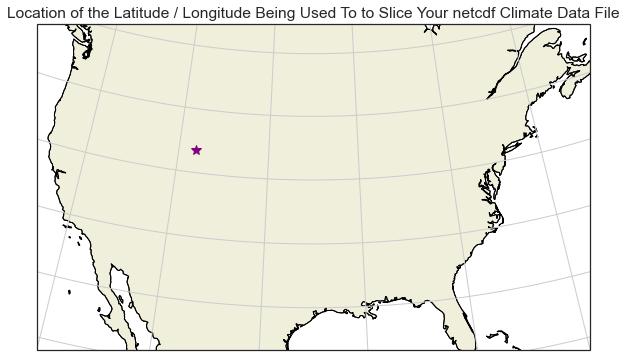

In [9]:
# Create a spatial map of your selected location with cartopy
extent =[-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Create your figure and axis object
# Albers equal area is a common CRS used to make maps of the United States
f, ax = plt.subplots(figsize=(12,6),
                    subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()

# Plot the selected location
ax.plot(longitude-360, latitude, 
        '*', 
        transform=ccrs.PlateCarree(),
        color="purple", 
        markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

## Subset The Data


In [10]:
# Slice the data spatially using a single lat/lon point
one_point = max_temp_xr["air_temperature"].sel(lat=latitude,
                                             lon=longitude)

one_point

<xarray.DataArray 'air_temperature' (time: 672)>
array([271.11615, 274.05585, 279.538  , ..., 286.85074, 279.6746 , 271.4411 ],
      dtype=float32)
Coordinates:
    lat      float64 41.73
    lon      float64 251.9
  * time     (time) object 1950-01-15 00:00:00 ... 2005-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [11]:
# Notice the shape of the output array
one_point.shape

(672,)

In [12]:
# View the first 5 values for that single point
one_point.values[:5]

array([271.11615, 274.05585, 279.538  , 284.42365, 294.1337 ],
      dtype=float32)

## Plot A Time Series For a Single Location


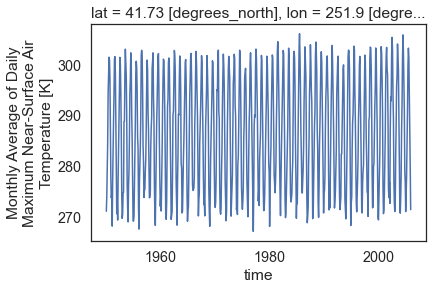

In [13]:
# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

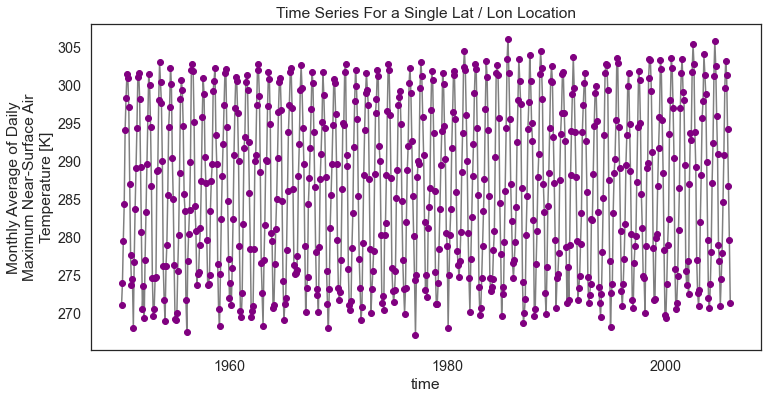

In [14]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(hue='lat',
                    marker="o",
                    ax=ax,
                    color="grey",
                    markerfacecolor="purple",
                    markeredgecolor="purple")
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

In [15]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

,lat,lon,air_temperature
time,,,
1950-01-15 00:00:00,41.729477,251.894226,271.116150
1950-02-15 00:00:00,41.729477,251.894226,274.055847
1950-03-15 00:00:00,41.729477,251.894226,279.537994
1950-04-15 00:00:00,41.729477,251.894226,284.423645
1950-05-15 00:00:00,41.729477,251.894226,294.133698


In [16]:
# Export data to .csv file
one_point_df.to_csv("one-location.csv")

In [17]:
start_date = "2000-01-01"
end_date = "2005-01-01"
temp_2000_2005 = max_temp_xr["air_temperature"].sel(time=slice(start_date, end_date),
                                                   lat=45.02109146118164,
                                                    lon=243.01937866210938)
temp_2000_2005

<xarray.DataArray 'air_temperature' (time: 60)>
array([273.74884, 277.1434 , 280.0702 , 280.6042 , 289.23993, 290.86853,
       297.70242, 301.36722, 296.4382 , 291.29434, 275.8434 , 273.0037 ,
       275.154  , 278.77863, 282.29105, 283.87787, 290.53387, 296.701  ,
       297.4607 , 301.16116, 295.5421 , 287.3863 , 276.85397, 274.35953,
       278.0117 , 275.68024, 282.12674, 286.41693, 292.4094 , 297.30606,
       300.84628, 302.10593, 288.83698, 288.44   , 276.38992, 276.5348 ,
       275.86145, 276.5708 , 280.8476 , 284.35712, 292.14087, 293.66147,
       301.09534, 302.7656 , 294.99573, 287.5425 , 277.80093, 273.25894,
       274.09232, 276.94736, 280.25446, 283.47614, 289.63776, 290.5187 ,
       301.8519 , 300.40402, 290.73633, 289.60886, 277.12424, 275.7836 ],
      dtype=float32)
Coordinates:
    lat      float64 45.02
    lon      float64 243.0
  * time     (time) object 2000-01-15 00:00:00 ... 2004-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [18]:
temp_2000_2005.shape


(60,)

In [19]:
# View the 60 data points (raster cell values) associated with the spatial and temporal subset
temp_2000_2005.values

array([273.74884, 277.1434 , 280.0702 , 280.6042 , 289.23993, 290.86853,
       297.70242, 301.36722, 296.4382 , 291.29434, 275.8434 , 273.0037 ,
       275.154  , 278.77863, 282.29105, 283.87787, 290.53387, 296.701  ,
       297.4607 , 301.16116, 295.5421 , 287.3863 , 276.85397, 274.35953,
       278.0117 , 275.68024, 282.12674, 286.41693, 292.4094 , 297.30606,
       300.84628, 302.10593, 288.83698, 288.44   , 276.38992, 276.5348 ,
       275.86145, 276.5708 , 280.8476 , 284.35712, 292.14087, 293.66147,
       301.09534, 302.7656 , 294.99573, 287.5425 , 277.80093, 273.25894,
       274.09232, 276.94736, 280.25446, 283.47614, 289.63776, 290.5187 ,
       301.8519 , 300.40402, 290.73633, 289.60886, 277.12424, 275.7836 ],
      dtype=float32)

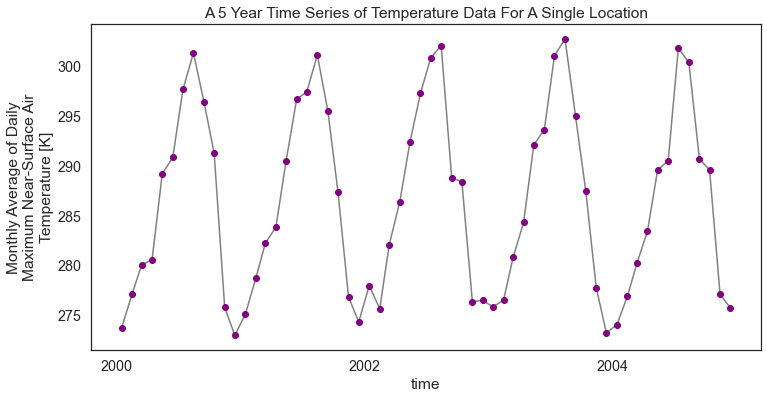

In [20]:
# Plot the data just like you did above
f, ax = plt.subplots(figsize=(12, 6))
temp_2000_2005.plot.line(hue='lat',
                         marker="o",
                         ax=ax,
                         color="grey",
                         markerfacecolor="purple",
                         markeredgecolor="purple")
ax.set(title="A 5 Year Time Series of Temperature Data For A Single Location")
plt.show()

In [21]:
# Convert to dataframe -- then this can be exported to a csv if you want that
temp_2000_2005_df = temp_2000_2005.to_dataframe()
#view just the first 5 rows of the dat
temp_2000_2005_df.head()

,lat,lon,air_temperature
time,,,
2000-01-15 00:00:00,45.021091,243.019379,273.748840
2000-02-15 00:00:00,45.021091,243.019379,277.143402
2000-03-15 00:00:00,45.021091,243.019379,280.070190
2000-04-15 00:00:00,45.021091,243.019379,280.604187
2000-05-15 00:00:00,45.021091,243.019379,289.239929


In [22]:
# Create filename from subset info
file_name = "monthly-temp-" + start_date + "-" + end_date + ".csv"
file_name

'monthly-temp-2000-01-01-2005-01-01.csv'

In [23]:
# Export to a csv file to share with your friends!
temp_2000_2005_df.to_csv(file_name)

## Slice The Data Across a Spatial Extent For A Specific Time Period


In [24]:
start_date = "1950-01-15"
end_date = "1950-02-15"

two_months_conus = max_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date))

# Notice that time has a value of **2** below representing two time steps or months worth of data
two_months_conus

<xarray.DataArray 'air_temperature' (time: 2, lat: 585, lon: 1386)>
[1621620 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * time     (time) object 1950-01-15 00:00:00 1950-02-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [25]:
two_months_conus.shape

(2, 585, 1386)

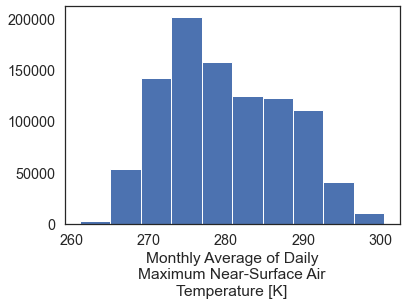

In [26]:
# Directly plot just a single day using time in "years"
two_months_conus.plot()
plt.show()

## Spatial Raster Plots of MACA v2 Climate Data


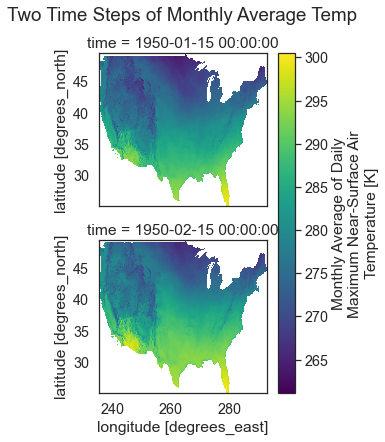

In [27]:
# Quickly plot the data using xarray.plot()
two_months_conus.plot(x="lon",
                     y="lat",
                     col="time",
                     col_wrap=1)
plt.suptitle("Two Time Steps of Monthly Average Temp", y=1.03)
plt.show()

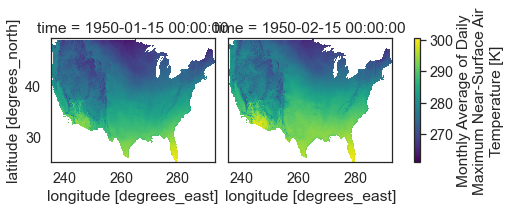

In [28]:
# Plot the data using 2 columns
two_months_conus.plot(x="lon",
                      y="lat",
                      col="time",
                      col_wrap=2)
plt.show()

## Plot Multiple MACA v2 Climate Data Raster Files With a Spatial Projection


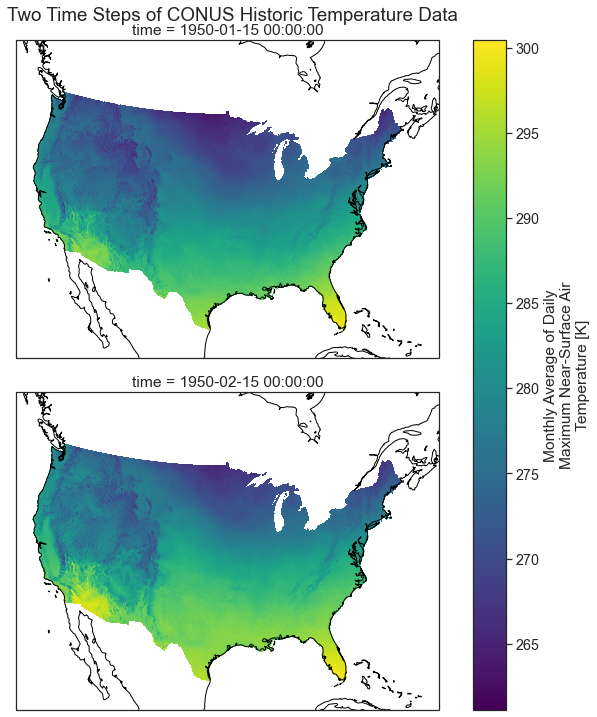

In [29]:
central_lat = 37.5
central_long = 96
extent = [-120, -70, 20, 55.5]  # CONUS

map_proj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                                central_latitude=central_lat)

aspect = two_months_conus.shape[2] / two_months_conus.shape[1]
p = two_months_conus.plot(transform=ccrs.PlateCarree(),  # the data's projection
                          col='time', col_wrap=1,
                          aspect=aspect,
                          figsize=(10, 10),
                          subplot_kws={'projection': map_proj})  # the plot's projection

plt.suptitle("Two Time Steps of CONUS Historic Temperature Data", y=1)
# Add the coastlines to each axis object and set extent
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(extent)

## Export Raster to Geotiff File


In [30]:
# Double check the crs still exist
two_months_conus.rio.crs

In [31]:
# Export to geotiff
file_path = "two_months_temp_data.tif"
two_months_conus.rio.to_raster(file_path)

In [33]:
# Open the data up as a geotiff
two_months_tiff = rxr.open_rasterio(file_path)
two_months_tiff

<xarray.DataArray (band: 2, y: 585, x: 1386)>
[1621620 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2
  * x            (x) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * y            (y) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
    spatial_ref  int32 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Monthly Average of Daily Maximum Near-Surface Air Temperature

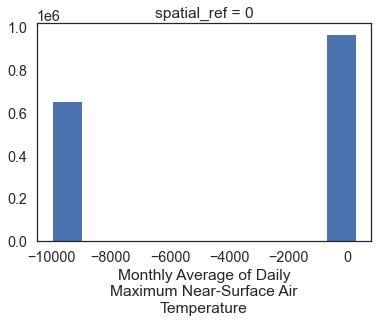

In [34]:
two_months_tiff.plot()
plt.show()

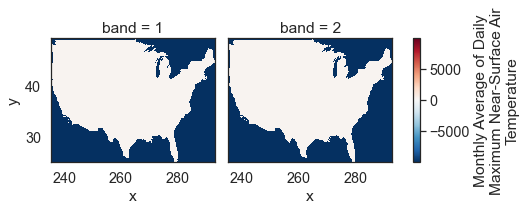

In [35]:
# Plot the data - this doesn't look right!
two_months_tiff.plot(col="band")
plt.show()

In [36]:
two_months_tiff.rio.nodata

-9999.0

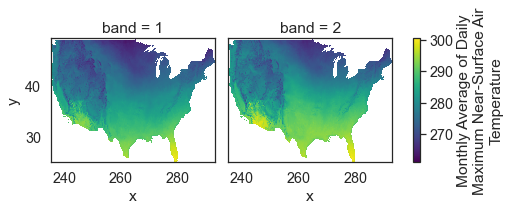

In [39]:
# Remove no data values and try to plot again
two_months_tiff = rxr.open_rasterio(file_path)

two_months_clean = two_months_tiff.where(
    two_months_tiff != two_months_tiff.rio.nodata)

two_months_clean.plot(col="band")
plt.show()